In [21]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import random
import time
from tqdm.notebook import tqdm

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import ZINC
import networkx as nx
from scipy import sparse as sp

from models import GraphRegressionGraphTransformer, GraphTransformerEdges, GraphTransformer, GraphRegressionGraphTransformerEdges, GraphRegressionGraphTransformerEdgesCustom
from preprocess import AddLaplacianPosEncoding, ZINCDataset, AddWLPosEncoding
from train import train_one_epoch, evaluate

In [22]:
SEED = 0

if torch.cuda.is_available():
    print('cuda available with GPU:',torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print('cuda not available')
    device = torch.device("cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)


cuda available with GPU: NVIDIA GeForce GTX 1660 Ti


# Parameters

In [31]:
# Dimension of positional encoding, ex number of non-trivial eigenvalues for laplacian positional encoding
POS_ENCODING_DIM = 6

# Training parameters
BATCH_SIZE = 128
INIT_LR = 0.0007
WEIGHT_DECAY = 0.0
LR_REDUCE_FACTOR = 0.5
PATIENCE = 15
MIN_LR = 1e-6
EPOCHS = 100

# Network parameters
n_hidden = 64
n_head = 8
n_feedforward = 128
n_layers = 5
input_dropout = 0.0
dropout = 0.0
norm = 'layer'
readout = 'mean'
pos_encoding = 'laplacian'

# Data

In [71]:
# Dataset and prior transforms
data_transforms = T.Compose([
    ZINCDataset(),
    AddLaplacianPosEncoding(POS_ENCODING_DIM),
    AddWLPosEncoding(),
    #T.AddSelfLoops('edge_attr')
    ])


dataset_train = ZINC('data/ZINC_noselfloops', subset=True, split='train', pre_transform=data_transforms)
dataset_val = ZINC('data/ZINC_noselfloops', subset=True, split='val', pre_transform=data_transforms)
dataset_test = ZINC('data/ZINC_noselfloops', subset=True, split='test', pre_transform=data_transforms)

In [72]:
# Dataloaders
dataloader_train = torch_geometric.loader.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = torch_geometric.loader.DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
dataloader_test = torch_geometric.loader.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [73]:
# Vocabulary sizes for nodes and edges, for embedding layers
n_nodes_input = torch.unique(dataset_train.x).size(0)
n_edges_input = torch.unique(dataset_train.edge_attr).size(0)+1

# Training and test

In [74]:
checkpoint_path = 'checkpoints/ZINC_noedges_noselfloops.pth'

"""model = GraphRegressionGraphTransformerEdges(n_nodes_input, 
                                             n_edges_input, 
                                             n_hidden, 
                                             n_head, 
                                             n_feedforward, 
                                             n_layers, 
                                             input_dropout=input_dropout, 
                                             dropout=dropout, 
                                             k=POS_ENCODING_DIM,
                                             pos_encoding='laplacian', 
                                             norm=norm,
                                             readout = readout)"""

model = GraphRegressionGraphTransformer(n_nodes_input, 
                                             n_hidden, 
                                             n_head, 
                                             n_feedforward, 
                                             n_layers, 
                                             input_dropout=input_dropout, 
                                             dropout=dropout, 
                                             k=POS_ENCODING_DIM, 
                                             pos_encoding=pos_encoding,
                                             norm=norm,
                                             readout = readout)

"""model = GraphRegressionGraphTransformerEdgesCustom(n_nodes_input, 
                                             n_edges_input, 
                                             n_hidden, 
                                             n_head, 
                                             n_feedforward, 
                                             n_layers, 
                                             input_dropout=input_dropout, 
                                             dropout=dropout, 
                                             k=POS_ENCODING_DIM,
                                             pos_encoding='laplacian', 
                                             norm=norm,
                                             readout = readout)"""

model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=INIT_LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=LR_REDUCE_FACTOR,
                                                 patience=PATIENCE,
                                                 verbose=True)

epoch_train_losses, epoch_val_losses = [], []
epoch_train_accs, epoch_val_accs = [], [] 

In [39]:
for epoch in range(EPOCHS):
    
    epoch_train_loss, optimizer = train_one_epoch(model, dataloader_train, epoch, device, optimizer, criterion, pos_encoding=pos_encoding)

    epoch_val_loss = evaluate(model, dataloader_val, device, criterion, pos_encoding=pos_encoding) 

    epoch_train_losses.append(epoch_train_loss)
    epoch_val_losses.append(epoch_val_loss)

    lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}/{EPOCHS}: Train loss = {epoch_train_loss:.4f}, Validation loss = {epoch_val_loss:.4f}, Learning rate = {lr}')

torch.save(model.state_dict(), checkpoint_path)

Epoch 100/100: Train loss = 0.3052, Validation loss = 0.4151, Learning rate = 0.0007


In [75]:
epoch_test_loss = evaluate(model, dataloader_test, device, criterion, pos_encoding=pos_encoding)
epoch_test_loss

0.45014187321066856

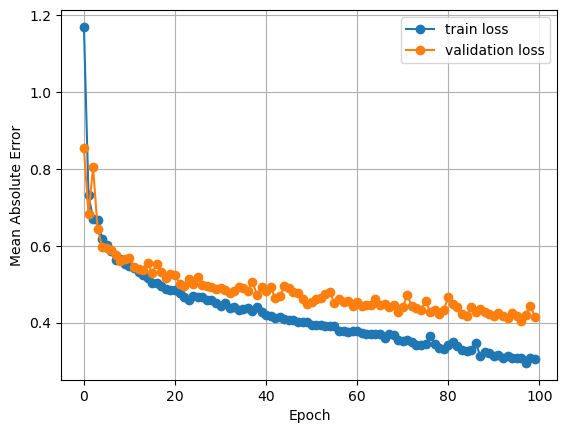

In [41]:
plt.plot(range(EPOCHS), epoch_train_losses, '-o', label='train loss')
plt.plot(range(EPOCHS), epoch_val_losses, '-o', label='validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.grid()

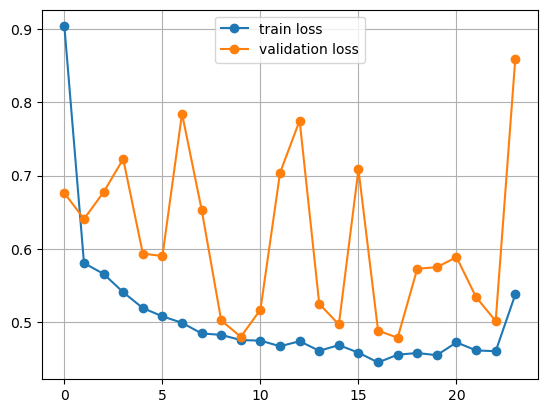

In [22]:
plt.plot(range(len(epoch_train_losses)), epoch_train_losses, '-o', label='train loss')
plt.plot(range(len(epoch_val_losses)), epoch_val_losses, '-o', label='validation loss')
plt.legend()
plt.grid()

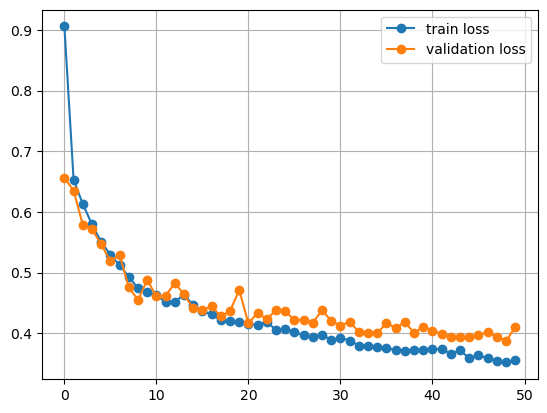

In [10]:
plt.plot(range(EPOCHS), epoch_train_losses, '-o', label='train loss')
plt.plot(range(EPOCHS), epoch_val_losses, '-o', label='validation loss')
plt.legend()
plt.grid()

In [9]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

192833

In [67]:
dataloader_vis = torch_geometric.loader.DataLoader(dataset_test[:3], batch_size=1, shuffle=True)

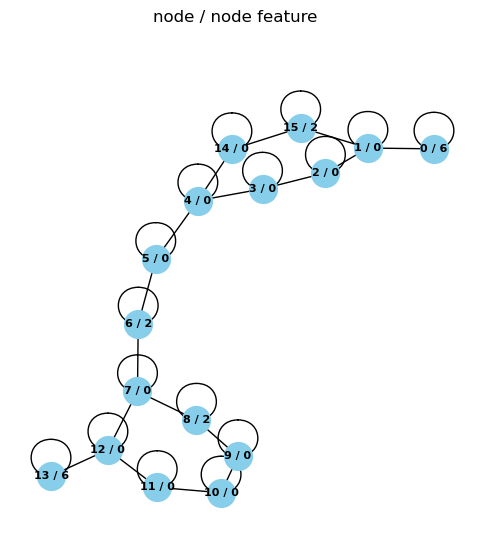

DataBatch(x=[16], edge_index=[2, 50], edge_attr=[50], y=[1], laplacian_eigs=[16, 6], wl_encoding=[16], batch=[16], ptr=[2])

In [68]:
g = next(iter(dataloader_vis))
def draw_graph(g):
    # Convert PyG graph to NetworkX graph
    nx_graph = nx.Graph()
    nx_graph.add_nodes_from(range(g.num_nodes))
    nx_graph.add_edges_from(g.edge_index.t().tolist())

    # Create subplots
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.suptitle('node / node feature')

    # Draw the graph with node features as labels
    pos = nx.spring_layout(nx_graph)  # You can use other layout algorithms as well
    nx.draw(nx_graph, pos, with_labels=True, 
            labels={i: f'{i} / {g.x[i].item()}' for i in range(g.num_nodes)}, 
            font_size=8, font_color='black', node_size=400, 
            node_color='skyblue', font_weight='bold', ax=ax)

    # Show the plot
    plt.show()

draw_graph(g)
g.to(device)
g

In [69]:
out, attention_scores = model(g, g.x, g.laplacian_eigs)

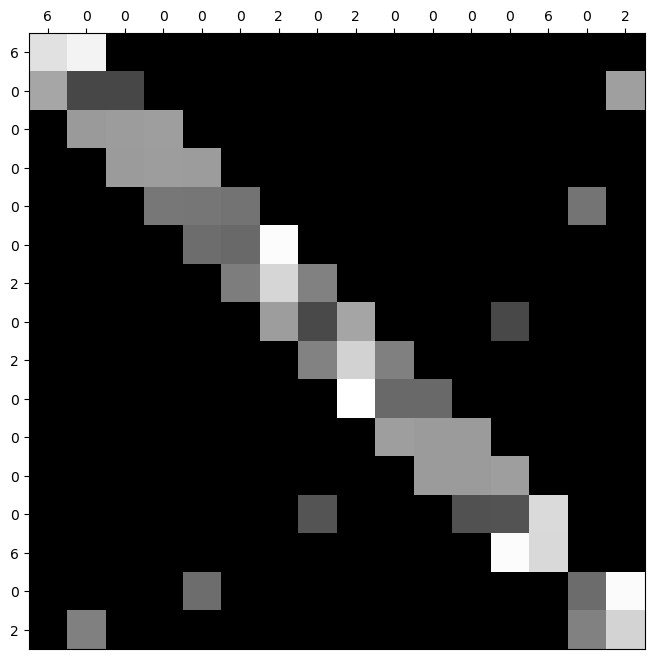

In [70]:
layer = 0
head = 5
attention_layer = attention_scores[layer]
att_plot = attention_layer[0].mean(axis=0)
#att_plot = attention_layer[0,head]
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(att_plot, cmap='gray')
ax.xaxis.tick_top()
plt.xticks(np.arange(len(g.x)), g.x.detach().cpu().numpy())
plt.yticks(np.arange(len(g.x)), g.x.detach().cpu().numpy())

plt.show()


In [116]:
checkpoint_path = 'checkpoints/ZINC_edges.pth'

model2 = GraphRegressionGraphTransformerEdges(n_nodes_input, 
                                             n_edges_input, 
                                             n_hidden, 
                                             n_head, 
                                             n_feedforward, 
                                             n_layers, 
                                             input_dropout=input_dropout, 
                                             dropout=dropout, 
                                             k=POS_ENCODING_DIM,
                                             pos_encoding='laplacian', 
                                             norm=norm,
                                             readout = readout)

model2.load_state_dict(torch.load(checkpoint_path))
model2 = model2.to(device)

In [117]:
out, attention_scores2 = model2(g, g.x, g.laplacian_eigs)

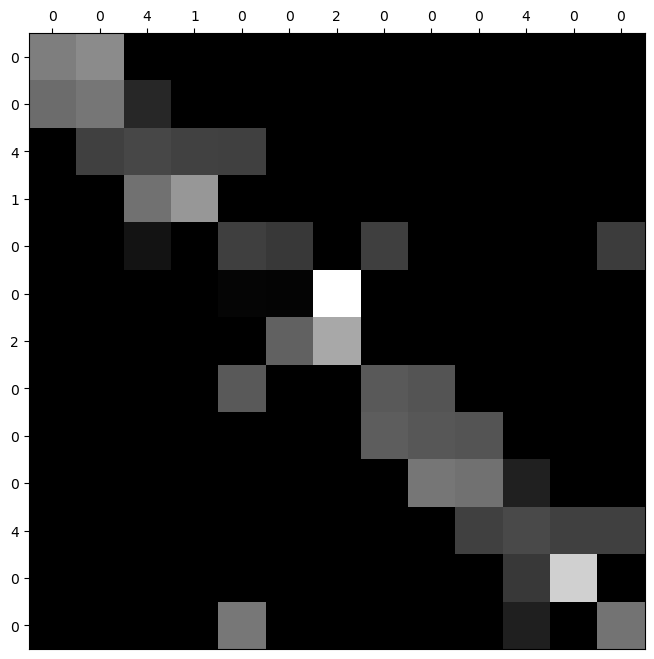

In [131]:
attention_layer = attention_scores2[layer]
#att_plot = attention_layer[0].mean(axis=0)
att_plot = attention_layer[0,head]
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(att_plot, cmap='gray')
ax.xaxis.tick_top()
plt.xticks(np.arange(len(g.x)), g.x.detach().cpu().numpy())
plt.yticks(np.arange(len(g.x)), g.x.detach().cpu().numpy())

plt.show()

In [51]:
checkpoint_path = 'checkpoints/ZINC_noedges.pth'

model3 = GraphRegressionGraphTransformer(n_nodes_input, 
                                             n_hidden, 
                                             n_head, 
                                             n_feedforward, 
                                             n_layers, 
                                             input_dropout=input_dropout, 
                                             dropout=dropout, 
                                             k=POS_ENCODING_DIM, 
                                             pos_encoding='laplacian',
                                             norm=norm,
                                             readout = readout)

model3.load_state_dict(torch.load(checkpoint_path))
model3 = model3.to(device)

In [52]:
out, attention_scores3 = model3(g, g.x, g.laplacian_eigs)

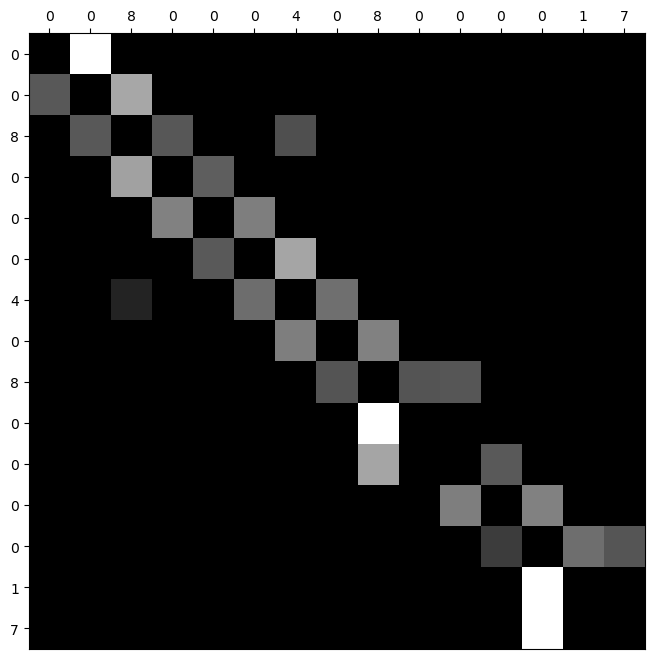

In [53]:
attention_layer = attention_scores3[layer]
#att_plot = attention_layer[0].mean(axis=0)
att_plot = attention_layer[0,head]
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(att_plot, cmap='gray')
ax.xaxis.tick_top()
plt.xticks(np.arange(len(g.x)), g.x.detach().cpu().numpy())
plt.yticks(np.arange(len(g.x)), g.x.detach().cpu().numpy())

plt.show()